In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
import cmasher as cmr
from juanfit import SpectrumFitSingle, SpectrumFitRow
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
import cv2


In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]



In [12]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_red.h5", 'r') as hf:
    xpos_map_coordinate = hf['xpos_map_coordinate'][:]
    xstart_pixel = hf['xpos_map_coordinate'].attrs['xstart_pixel']
    xend_pixel = hf['xpos_map_coordinate'].attrs['xend_pixel']

    ypos_map_coordinate = hf['ypos_map_coordinate'][:]
    ystart_pixel = hf['ypos_map_coordinate'].attrs['ystart_pixel']
    yend_pixel = hf['ypos_map_coordinate'].attrs['yend_pixel']


In [19]:
green_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"

In [13]:
totality_image_fname = "TotalitySequenceRed_7723.fit"
totality_frame = CCDData.read(os.path.join(red_path, totality_image_fname),unit="adu")

In [14]:
with fits.open(os.path.join(red_path, totality_image_fname)) as hdul:
    hdul.info()

Filename: ../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/TotalitySequenceRed_7723.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (1392, 1040)   int16 (rescales to uint16)   


In [15]:
totality_frame.meta

SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1392                                                  
NAXIS2  =                 1040                                                  
BZERO   =           32768.000000                                                
BSCALE  =             1.000000                                                  
DATAMIN =             0.000000                                                  
DATAMAX =           65535.000000                                                
INSTRUME=           'Infinity: fw rev 2.00'                                     
FILTER  =           'Position 0'                                                
EXPTIME =           1.000                                                       
DATE-OBS=           '2017-08

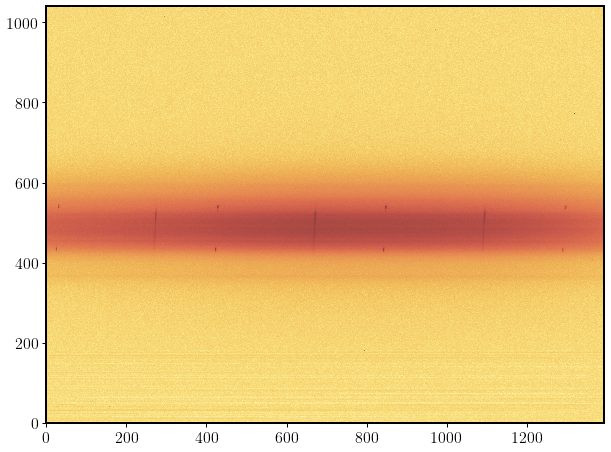

In [16]:
totality_image = (totality_frame.data - bias_dc_red_1s)//totality_frame.header["EXPTIME"]
norm_totality = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm_totality,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)

In [17]:
testx_slice_mapcoor = slice(xstart_pixel,xend_pixel)
testy_slice_mapcoor = slice(ystart_pixel,yend_pixel)
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

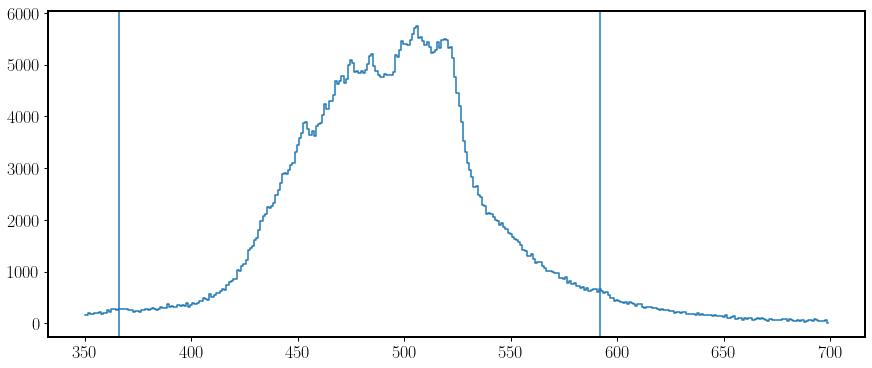

In [33]:
fig, ax = plt.subplots(figsize=(12,5),constrained_layout=True)
ax.step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop), 
        np.mean(totality_trans_mapcoor[:,665-xstart_pixel:669-xstart_pixel],axis=1),where="mid")
north_limb = 592
south_limb = 366
ax.axvline(south_limb)
ax.axvline(north_limb)
ax.tick_params(labelsize=18)

In [9]:
def ypixel_to_solary(ccdy_pixel):
    return (np.float64(ccdy_pixel) - (north_limb+south_limb)/2.)/(north_limb-south_limb+1)*2.

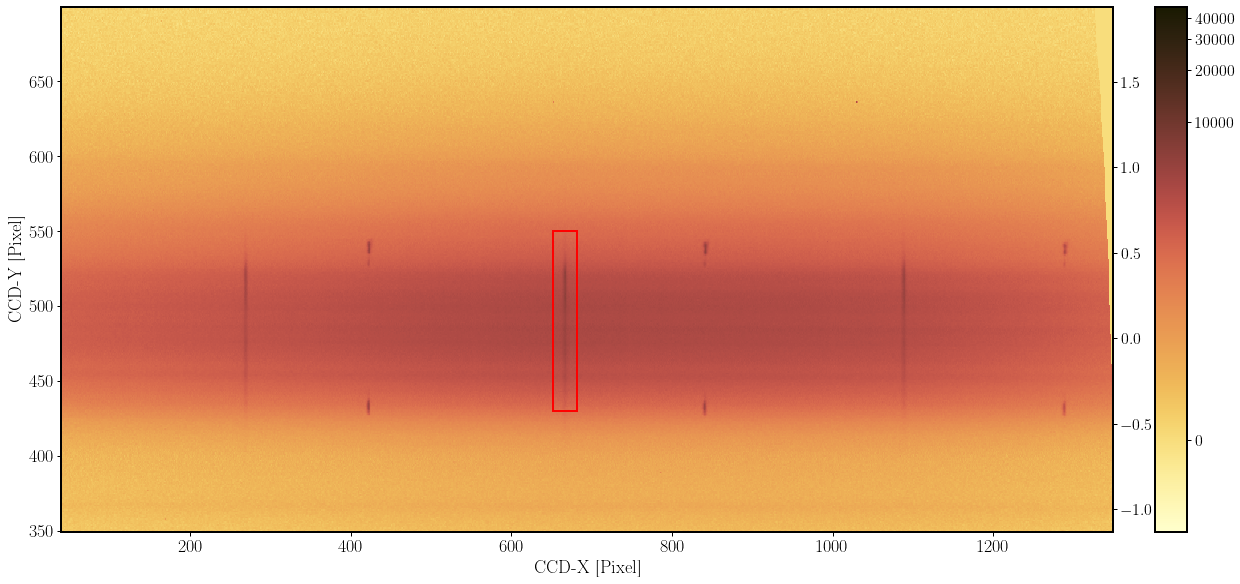

In [10]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,norm=norm_totality,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
FeX_6374_52th_xslice = slice(612,642)
FeX_6374_52th_yslice = slice(430 - ystart_pixel,550 - ystart_pixel)
solar_ycoord = ypixel_to_solary(np.arange(1040,dtype=np.float64))
solar_ycoord = solar_ycoord[testy_slice_mapcoor]
FeX_6374_52th_ycoord = solar_ycoord[FeX_6374_52th_yslice]

ax_solary = ax.twinx()
ax_solary_bot, ax_solary_top =  ypixel_to_solary(ax.get_ylim())
ax_solary.set_ylim(ax_solary_bot, ax_solary_top)
ax_solary.tick_params(labelsize=16)

ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)

cutout_rectangle_52th = Rectangle((FeX_6374_52th_xslice.start + xstart_pixel, FeX_6374_52th_yslice.start + ystart_pixel), 
                    FeX_6374_52th_xslice.stop - FeX_6374_52th_xslice.start,
                    FeX_6374_52th_yslice.stop - FeX_6374_52th_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(cutout_rectangle_52th)

clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.04, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)
plt.savefig(fname="../../figs/calib/data_example_red_7723_curvature_corr.png",format="png",dpi=150)

In [22]:
totality_image_green_fname = "TotalitySequenceGreen_22718(3).fit"
totality_green_frame = CCDData.read(os.path.join(green_path, totality_image_green_fname),unit="adu")

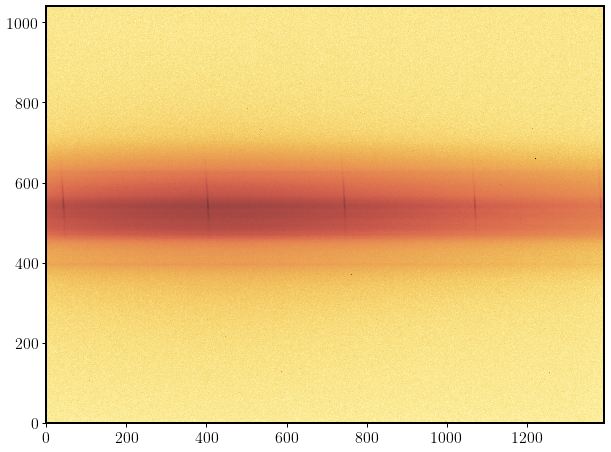

In [23]:
totality_image_green = (totality_green_frame.data - bias_dc_red_1s)//totality_green_frame.header["EXPTIME"]
norm_green_totality = ImageNormalize(totality_image_green, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image_green,norm=norm_green_totality,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)

In [24]:
totality_trans_mapcoor_green = ndimage.map_coordinates(totality_image_green[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

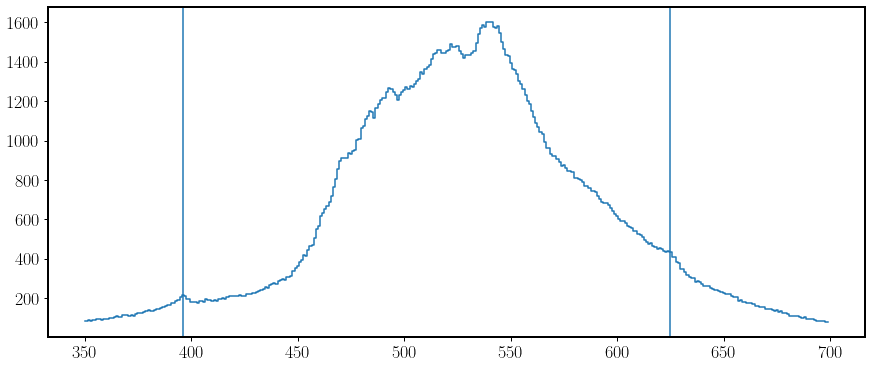

In [36]:
fig, ax = plt.subplots(figsize=(12,5),constrained_layout=True)
ax.step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop), 
        np.mean(totality_trans_mapcoor_green[:,800-xstart_pixel:820-xstart_pixel],axis=1),where="mid")
north_limb_green = 625
south_limb_green = 396
ax.axvline(south_limb_green)
ax.axvline(north_limb_green)
ax.tick_params(labelsize=18)

In [11]:
with Image.open("../../sav/Eclipse/Video/frame112.jpg") as im:
    totality_context = np.asarray(im)

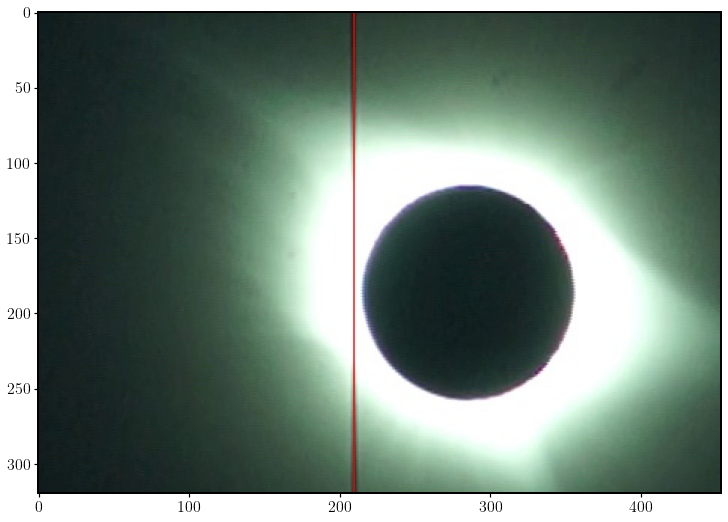

In [12]:
video_vertical_slice =  slice(390,710)
video_horizontal_slice = slice(746,1200)

slit_pos = 209.4
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context[video_vertical_slice,video_horizontal_slice,:])
ax.axvline(slit_pos,color="red",lw=2,alpha=0.7)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
plt.savefig(fname="../../figs/calib/data_example_context.png",format="png",dpi=150)

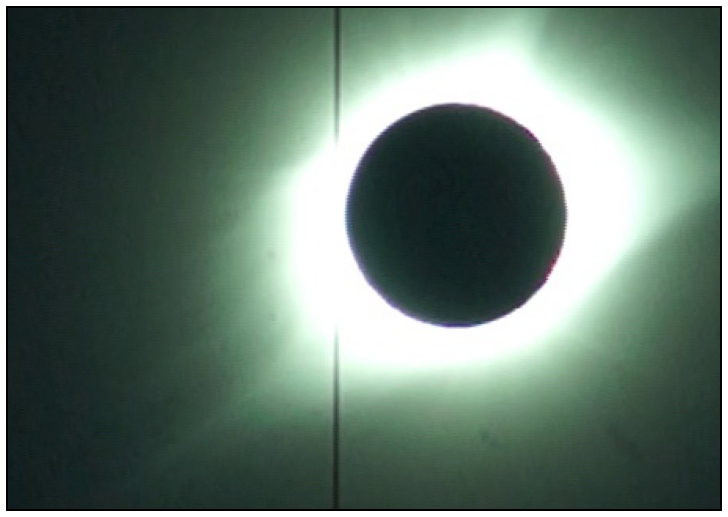

In [13]:
totality_context_flip = np.flip(totality_context[video_vertical_slice,video_horizontal_slice,:],axis=0)
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context_flip)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#plt.savefig("../../figs/WL_context_ud_flip.png",format="png",dpi=300)

In [48]:
totality_context_flip_gray = cv2.cvtColor(totality_context_flip, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(totality_context_flip_gray, cv2.HOUGH_GRADIENT, 1, 1000,param1=15, param2=10, minRadius=50, maxRadius=90)

In [55]:
circles

array([[[284.5, 132.5,  70.5]]], dtype=float32)

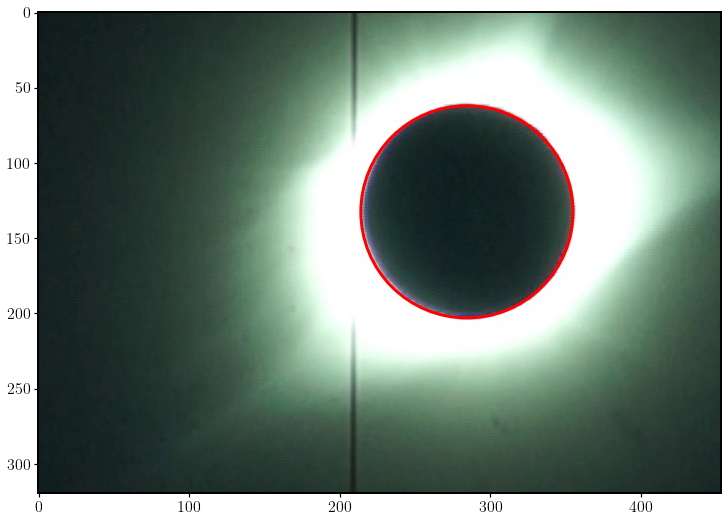

In [53]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context_flip)
if circles is not None:
    for circle_ in circles[0]:
        circle_x, circle_y, circle_radius = circle_
        circle_plot = plt.Circle((circle_x, circle_y), circle_radius, color='red',fill=False,lw=3)
        ax.add_patch(circle_plot)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)

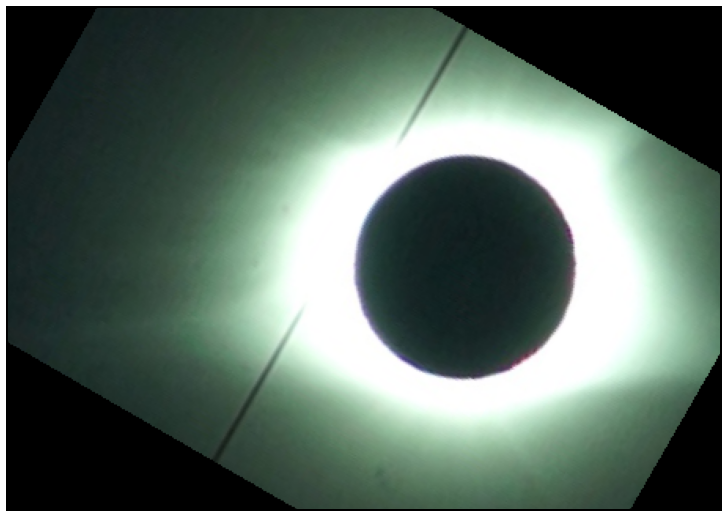

In [100]:
rotate_angle_context = -30
totality_context_rot_scipy = ndimage.rotate(totality_context_flip, angle=rotate_angle_context,reshape=False,order=1)
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context_rot_scipy)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#plt.savefig("../../figs/WL_context_ud_flip.png",format="png",dpi=300)

In [15]:
with h5py.File("../../sav/Eclipse/Wavelength/master_wavelength_curvature_red.h5", 'r') as hf:
    wavelength_times_order = hf['wavelength_times_order'][:]

In [16]:
wavelength_52th = wavelength_times_order/52.

In [17]:
FeX_6374_52th_data = totality_trans_mapcoor[FeX_6374_52th_yslice, FeX_6374_52th_xslice]
FeX_6374_52th_data_aver = np.mean(FeX_6374_52th_data.reshape((-1,5,30)),axis=1)
FeX_6374_52th_wvl = wavelength_52th[FeX_6374_52th_xslice]
FeX_6374_52th_ycoord_aver = np.mean(FeX_6374_52th_ycoord.reshape(-1,5),axis=1)

FeX_6374_52th_models = SpectrumFitRow(data=FeX_6374_52th_data_aver,wvl=FeX_6374_52th_wvl,line_number=1,
                                        line_wvl_init=6374.5,int_max_init=800,fwhm_init=1)

In [18]:
FeX_6374_52th_models.run_lse()

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


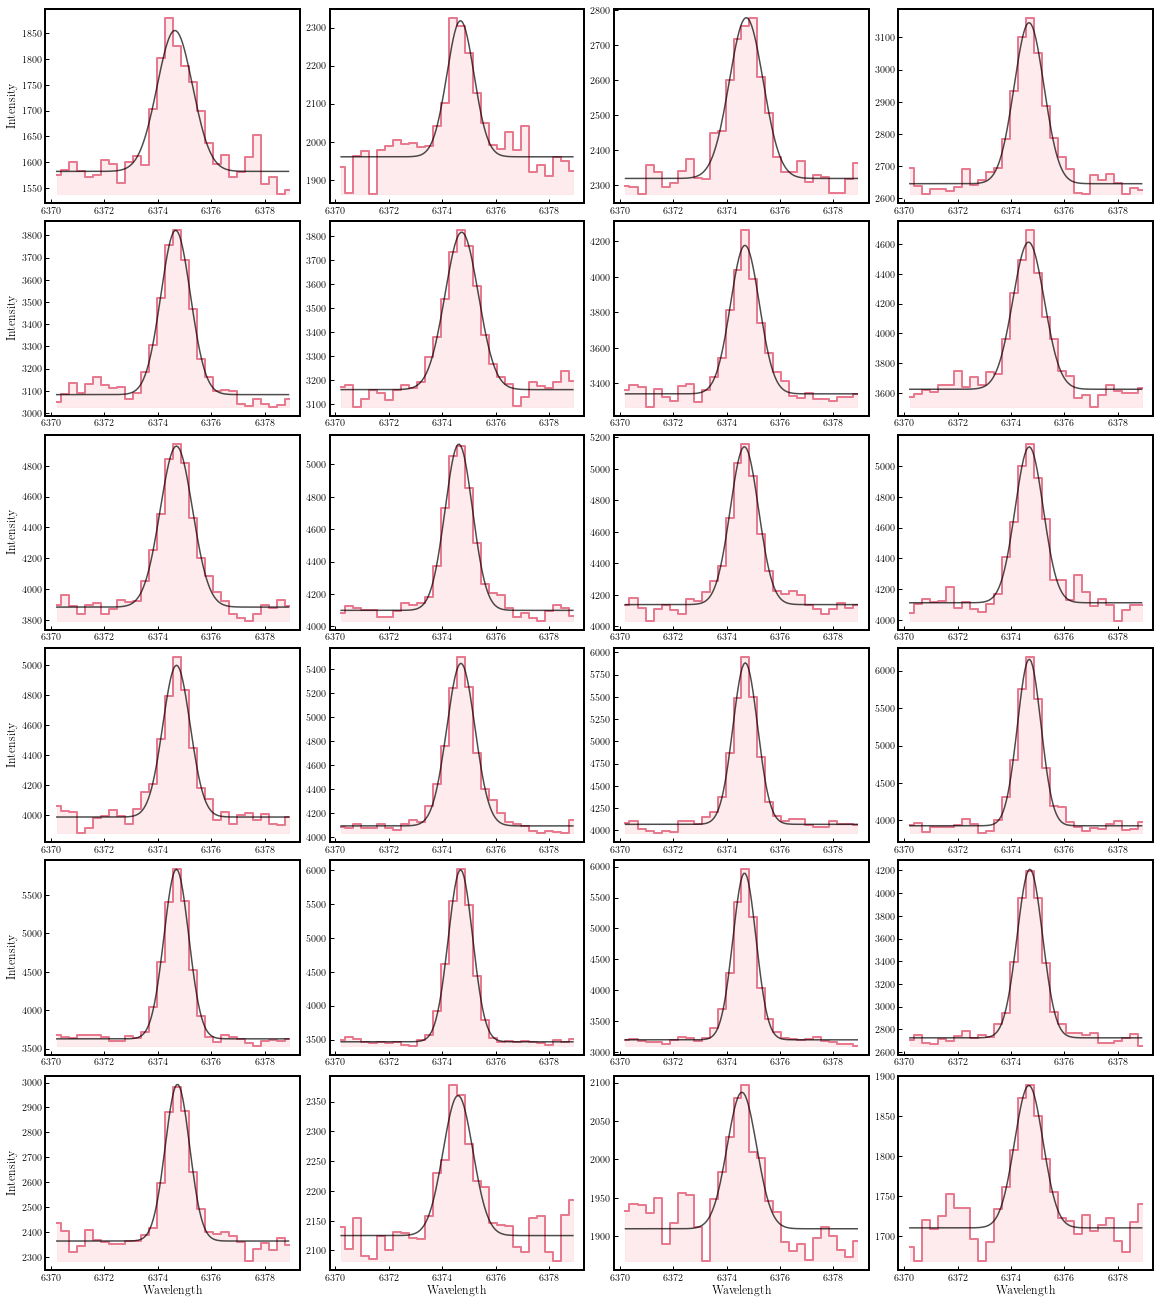

In [19]:
axes = FeX_6374_52th_models.plot_fit()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


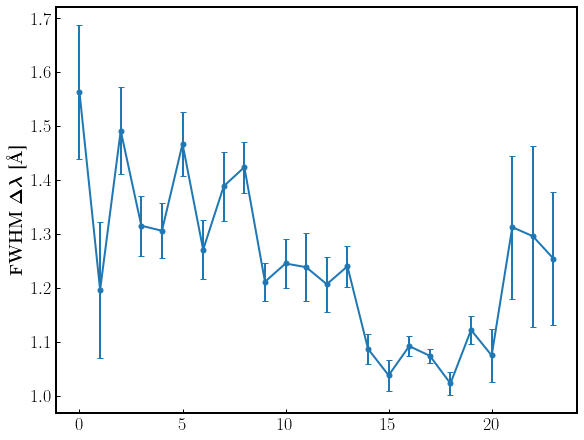

In [20]:
FeX_6374_52th_models.plot_variation(
                                    ylabel=r"\textbf{FWHM}\ $\boldsymbol{\Delta \lambda\ }$\textbf{[\mbox{\AA}]}")
plt.savefig(fname="../../figs/calib/data_fwhm_red_7723.png",format="png",dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


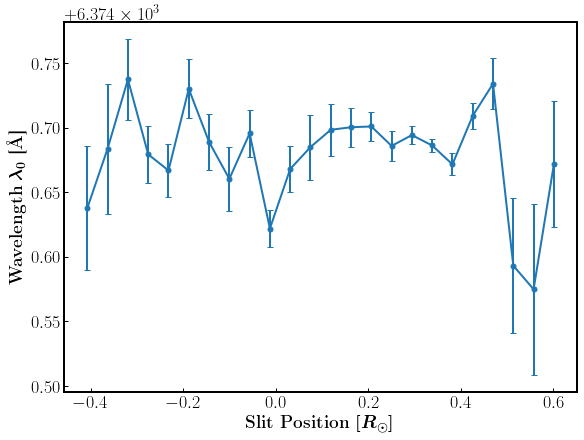

In [21]:
ax = FeX_6374_52th_models.plot_variation(var="wvl",xdata=FeX_6374_52th_ycoord_aver,xlabel=r"\textbf{Slit Position}\ $\boldsymbol{[R_\odot]}$",
                                    ylabel=r"\textbf{Wavelength}\ $\boldsymbol{\lambda_0\ }$\textbf{[\mbox{\AA}]}")
ax.yaxis.get_offset_text().set_fontsize(18)
plt.savefig(fname="../../figs/calib/data_linewvl_red_7723.png",format="png",dpi=150)

In [22]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
sun_center

(371.9, 382.85)

In [98]:
FeXI_line_cont_frame.header["SUNR"]

'123.05'

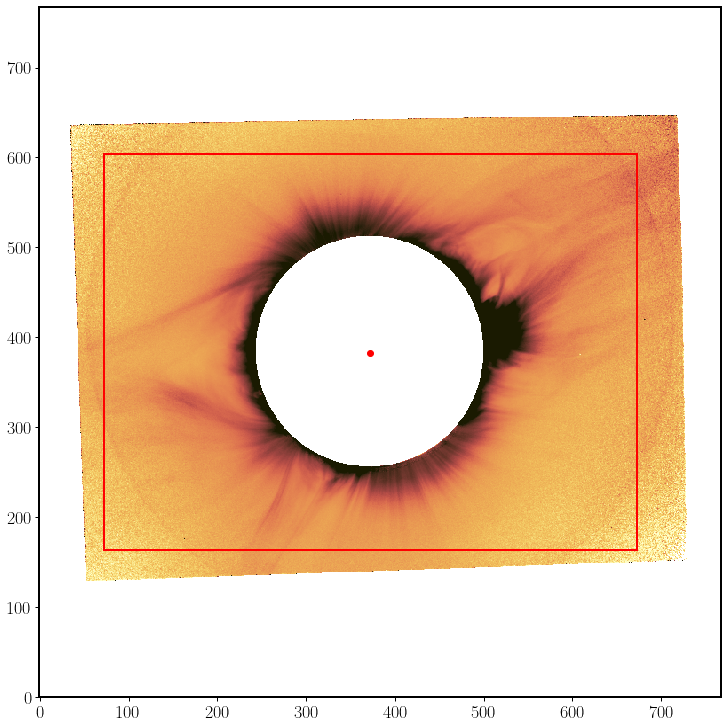

In [121]:
norm_FeXI_line_cont = ImageNormalize(FeXI_line_cont_image, interval=ZScaleInterval())
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)


fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
ax.pcolormesh(np.arange(FeXI_line_cont_frame.header["NAXIS1"]),np.arange(FeXI_line_cont_frame.header["NAXIS2"]),
                FeXI_line_cont_image,rasterized=True,cmap=cmcm.lajolla,norm=norm_FeXI_line_cont)

cutout_FeXI_line_cont = Rectangle((FeXI_line_cont_xslice.start, FeXI_line_cont_yslice.start), 
                    FeXI_line_cont_xslice.stop - FeXI_line_cont_xslice.start,
                    FeXI_line_cont_yslice.stop - FeXI_line_cont_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(cutout_FeXI_line_cont)

ax.tick_params(labelsize=18)
ax.scatter(sun_center[0],sun_center[1],color="red")


In [33]:
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center[0] - FeXI_line_cont_xslice.start, sun_center[1] - FeXI_line_cont_yslice.start)

In [34]:
FeXI_line_cont_image_rotmatrix = cv2.getRotationMatrix2D(center=FeXI_rotate_center, angle=np.float64(FeXI_line_cont_frame.header["SUNROT"]), scale=1)
FeXI_line_cont_image_rot = cv2.warpAffine(src=FeXI_line_cont_cutout, M=FeXI_line_cont_image_rotmatrix,
                dsize=FeXI_line_cont_cutout.shape,flags=cv2.INTER_LINEAR)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [35]:
FeXI_line_cont_image_rot_scipy.shape

(441, 601)

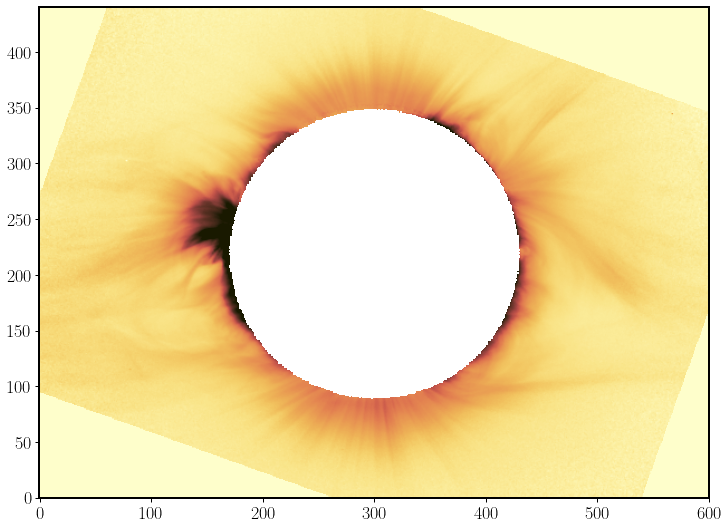

In [126]:
fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
ax.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla,origin="lower")
ax.tick_params(labelsize=18)
plt.savefig("../../figs/FeXI_reference_ben.png",format="png",dpi=300)
# ax.pcolormesh(np.arange(FeXI_line_cont_frame.header["NAXIS1"]),np.arange(FeXI_line_cont_frame.header["NAXIS2"]),
#                 FeXI_line_cont_image_rot,rasterized=True,cmap=cmcm.lajolla_r,norm=norm_FeXI_line_cont)

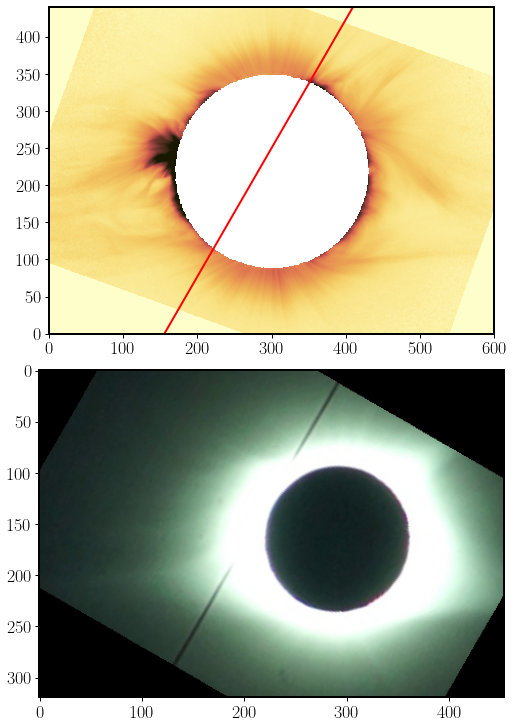

In [104]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10),constrained_layout=True)
ax1.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla,origin="lower")
ax2.imshow(totality_context_rot_scipy)

ax1.axline((300,250),slope=1/np.tan(np.deg2rad(np.abs(rotate_angle_context))),color="red",lw=2)


for ax_ in (ax1,ax2):   
    ax_.tick_params(labelsize=18)
    ax_.axis("scaled")

In [65]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos.h5", 'r') as hf:
    sun_x = hf['sun_x'][:]
    sun_y = hf['sun_y'][:]
    rsun = hf['rsun'][:]

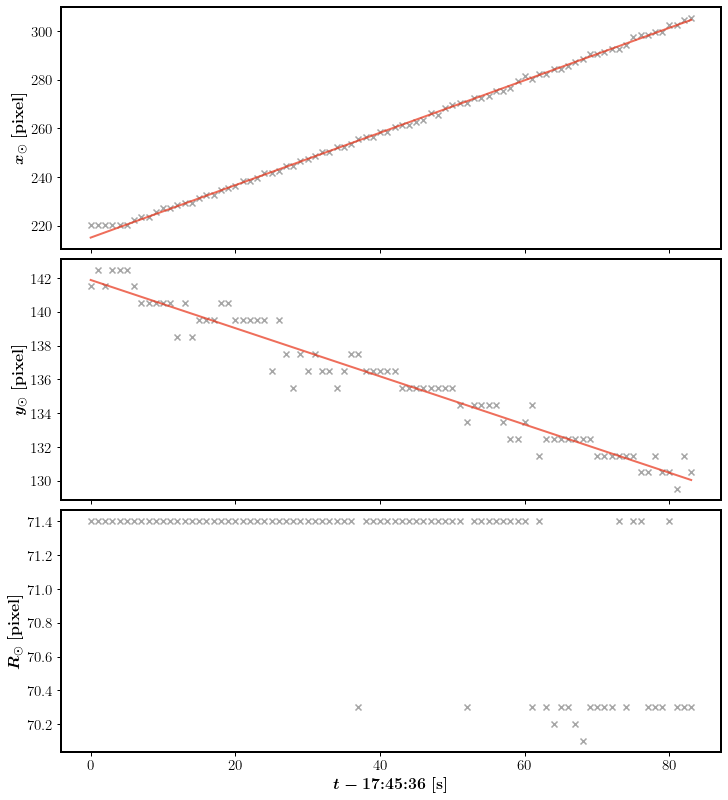

In [89]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,11),constrained_layout=True)

n_data_tofit = sun_x.shape[0] - 5
time_index_tofit = np.arange(5,5+n_data_tofit,dtype=np.float64)
sun_x_tofit = sun_x[5:]
sun_y_tofit = sun_y[5:]

sun_x_fitparam = np.polyfit(time_index_tofit, sun_x_tofit, 1)
sun_y_fitparam = np.polyfit(time_index_tofit, sun_y_tofit, 1)
sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

ax1.scatter(np.arange(0,sun_x.shape[0],dtype=np.float64),sun_x,marker="x",color="grey",alpha=0.7)
ax1.plot(np.linspace(0,sun_x.shape[0] - 1,100),sun_x_fitpoly(np.linspace(0,sun_x.shape[0] - 1,100)),lw=2,alpha=0.7,color="#E83015")
ax2.scatter(np.arange(0,sun_y.shape[0],dtype=np.float64),sun_y,marker="x",color="grey",alpha=0.7)
ax2.plot(np.linspace(0,sun_y.shape[0] - 1,100),sun_y_fitpoly(np.linspace(0,sun_y.shape[0] - 1,100)),lw=2,alpha=0.7,color="#E83015")
ax3.scatter(np.arange(0,rsun.shape[0],dtype=np.float64),rsun,marker="x",color="grey",alpha=0.7)

ax1.set_ylabel(r"$\boldsymbol{x_\odot\ \mathrm{[pixel]}}$",fontsize=16)
ax2.set_ylabel(r"$\boldsymbol{y_\odot\ \mathrm{[pixel]}}$",fontsize=16)
ax3.set_ylabel(r"$\boldsymbol{R_\odot\ \mathrm{[pixel]}}$",fontsize=16)

ax3.set_xlabel(r"$\boldsymbol{t - 17{:}45{:}36\ \mathrm{[s]}}$",fontsize=16)
for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelsize=15)

for ax_ in (ax1,ax2):
    ax_.tick_params(labelbottom=False)

In [157]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'w') as hf:
    df_sunx = hf.create_dataset("sun_x_fitparam",  data=sun_x_fitparam)
    df_suny = hf.create_dataset("sun_y_fitparam",  data=sun_y_fitparam)

Text(0.5, 1.0, '\\textbf{Fe \\textsc{xi}}')

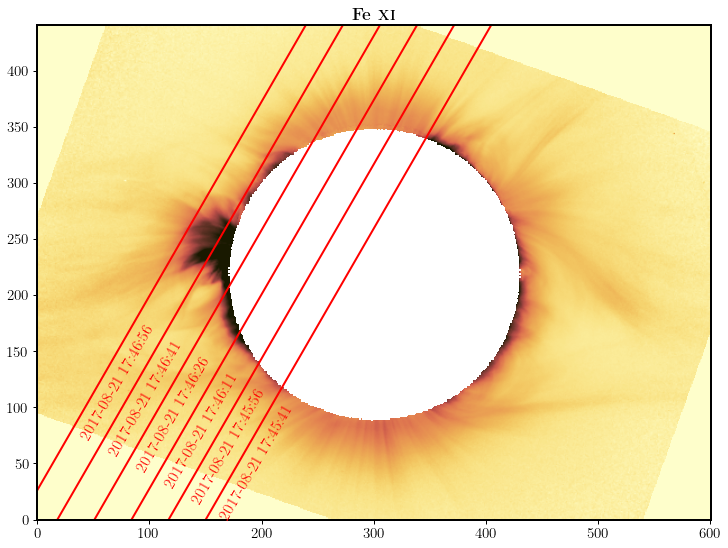

In [154]:
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
sun_center_pixel_plot = np.array([300,220])

pixel_ratio = 71.4/np.float64(FeXI_line_cont_frame.header["MOONR"])

time_index_select_to_plot = np.arange(5,n_data_tofit+5,15,dtype=np.float64)
time_select_to_plot = np.arange(datetime(2017,8,21,17,45,36+5),datetime(2017,8,21,17,47,0),timedelta(seconds=15)).astype(datetime)
slit_xshift_select = sun_x_fitpoly(time_index_select_to_plot) - slit_pos


slit_start_x_select = sun_center_pixel_plot[0] - slit_xshift_select/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_start_y_select = sun_center_pixel_plot[1] + slit_xshift_select/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

text_start_x_select = sun_center_pixel_plot[0] - (slit_xshift_select - 8)/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context))) \
                        - 200*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
text_start_y_select = sun_center_pixel_plot[1] + (slit_xshift_select - 8)/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context))) \
                        - 200*np.cos(np.deg2rad(np.abs(rotate_angle_context)))


for ii, time_select_to_plot_ in enumerate(time_select_to_plot):
    ax.axline((slit_start_x_select[ii],slit_start_y_select[ii]),slope=1/np.tan(np.deg2rad(np.abs(rotate_angle_context))),color="red",lw=2)
    ax.text(text_start_x_select[ii],text_start_y_select[ii],"{}".format(time_select_to_plot_),fontsize=16,color="red",
            ha="center",va="center",rotation=90 - np.abs(rotate_angle_context))

ax.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla,origin="lower")
ax.axis("scaled")
ax.tick_params(labelsize=15)
ax.set_title(r"\textbf{Fe \textsc{xi}}",fontsize=18)

In [150]:
slit_xshift_select

array([11.12848101, 27.30058423, 43.47268744, 59.64479065, 75.81689387,
       91.98899708])

In [151]:
time_index_select_to_plot

array([ 5., 20., 35., 50., 65., 80.])

In [120]:
FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
sun_center_FeXIV

(371.9, 382.85)

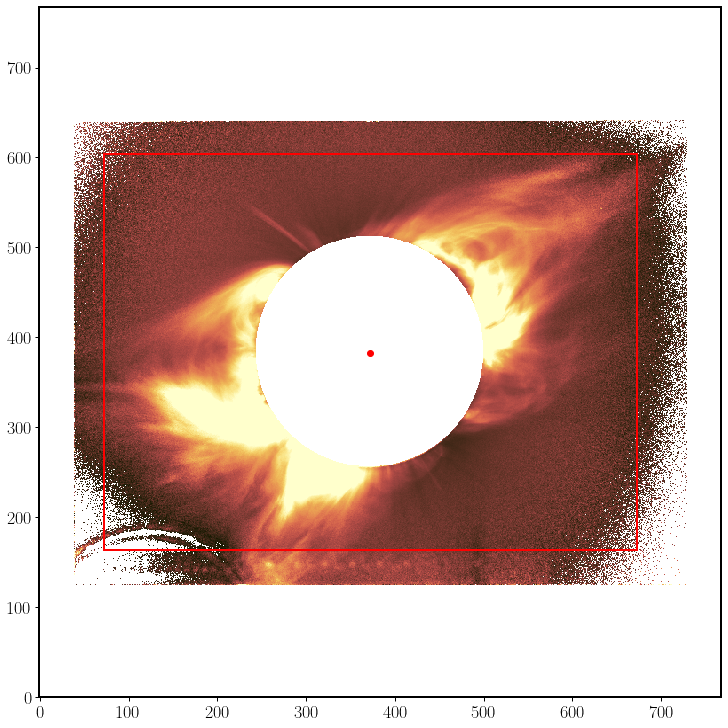

In [123]:
norm_FeXIV_line_cont = ImageNormalize(FeXIV_line_cont_image, interval=ZScaleInterval())
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)


fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
ax.pcolormesh(np.arange(FeXIV_line_cont_frame.header["NAXIS1"]),np.arange(FeXIV_line_cont_frame.header["NAXIS2"]),
                FeXIV_line_cont_image,rasterized=True,cmap=cmcm.lajolla_r,norm=norm_FeXIV_line_cont)

cutout_FeXIV_line_cont = Rectangle((FeXIV_line_cont_xslice.start, FeXIV_line_cont_yslice.start), 
                    FeXIV_line_cont_xslice.stop - FeXIV_line_cont_xslice.start,
                    FeXIV_line_cont_yslice.stop - FeXIV_line_cont_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(cutout_FeXIV_line_cont)

ax.tick_params(labelsize=18)
ax.scatter(sun_center_FeXIV[0],sun_center_FeXIV[1],color="red")


In [124]:
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

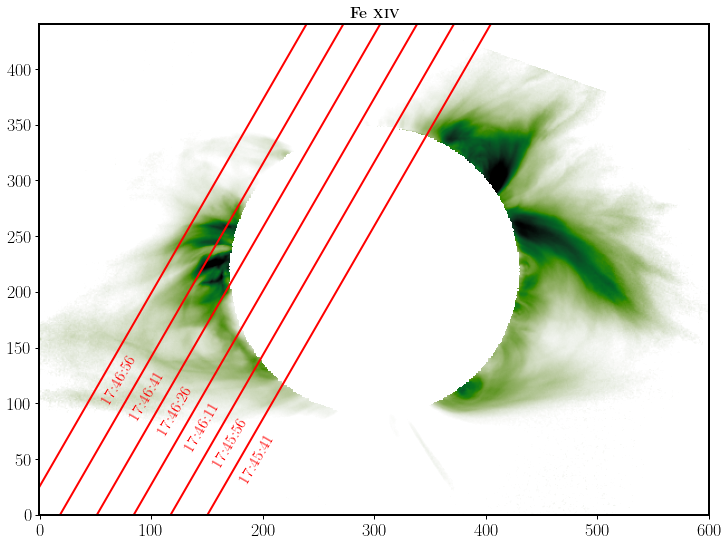

In [155]:
fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
im = ax.imshow(FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,cmap=cmr.jungle_r,origin="lower")
ax.tick_params(labelsize=18)
ax.set_title(r"\textbf{Fe \textsc{xiv}}",fontsize=16)
for ii, time_select_to_plot_ in enumerate(time_select_to_plot):
    ax.axline((slit_start_x_select[ii],slit_start_y_select[ii]),slope=1/np.tan(np.deg2rad(np.abs(rotate_angle_context))),color="red",lw=2)
    ax.text(text_start_x_select[ii],text_start_y_select[ii],time_select_to_plot_.strftime("%H:%M:%S"),fontsize=16,color="red",
            ha="center",va="center",rotation=90 - np.abs(rotate_angle_context))

In [159]:
totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

In [160]:
totality_green_df

file  simple  bitpix  naxis  naxis1  \
0                 TotalitySequenceGreen.fit    True      16      2    1392   
1             TotalitySequenceGreenTest.fit    True      16      2    1392   
2    TotalitySequenceGreenTest_22657(2).fit    True      16      2    1392   
3    TotalitySequenceGreenTest_22657(3).fit    True      16      2    1392   
4       TotalitySequenceGreenTest_22657.fit    True      16      2    1392   
..                                      ...     ...     ...    ...     ...   
315      TotalitySequenceGreen_22753(2).fit    True      16      2    1392   
316      TotalitySequenceGreen_22753(3).fit    True      16      2    1392   
317         TotalitySequenceGreen_22753.fit    True      16      2    1392   
318      TotalitySequenceGreen_22754(2).fit    True      16      2    1392   
319         TotalitySequenceGreen_22754.fit    True      16      2    1392   

     naxis2    bzero  bscale  datamin  datamax  ... xbinning  ybinning  \
0      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
1      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
2      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
3      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
4      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
..      ...      ...     ...      ...      ...  ...      ...       ...   
315    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
316    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
317    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
318    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
319    1040  32768.0     1.0      0.0  65535.0  ...        1         1   

    xorgsubf  yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  \
0          0         0         0         0     801   25634  Artemis Capture   
1          0         0         0         0     884   54763  Artemis Capture   
2          0         0         0         0    1154   65535  Artemis Capture   
3          0         0         0         0    1629   65535  Artemis Capture   
4          0         0         0         0    1019   65535  Artemis Capture   
..       ...       ...       ...       ...     ...     ...              ...   
315        0         0         0         0     798    1076  Artemis Capture   
316        0         0         0         0     797    1366  Artemis Capture   
317        0         0         0         0     793     990  Artemis Capture   
318        0         0         0         0     800    1083  Artemis Capture   
319        0         0         0         0     790     987  Artemis Capture   

         filter  
0           NaN  
1           NaN  
2    Position 0  
3    Position 0  
4    Position 0  
..          ...  
315  Position 0  
316  Position 0  
317  Position 0  
318  Position 0  
319  Position 0  

[320 rows x 25 columns]

In [161]:
totality_red_df

file  simple  bitpix  naxis  naxis1  \
0                TotalitySequenceRed.fit    True      16      2    1392   
1            TotalitySequenceRedTest.fit    True      16      2    1392   
2    TotalitySequenceRedTest_7651(2).fit    True      16      2    1392   
3       TotalitySequenceRedTest_7651.fit    True      16      2    1392   
4    TotalitySequenceRedTest_7652(2).fit    True      16      2    1392   
..                                   ...     ...     ...    ...     ...   
244      TotalitySequenceRed_7765(2).fit    True      16      2    1392   
245         TotalitySequenceRed_7765.fit    True      16      2    1392   
246      TotalitySequenceRed_7766(2).fit    True      16      2    1392   
247         TotalitySequenceRed_7766.fit    True      16      2    1392   
248         TotalitySequenceRed_7767.fit    True      16      2    1392   

     naxis2    bzero  bscale  datamin  datamax  ... xbinning  ybinning  \
0      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
1      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
2      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
3      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
4      1040  32768.0     1.0      0.0  65535.0  ...        1         1   
..      ...      ...     ...      ...      ...  ...      ...       ...   
244    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
245    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
246    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
247    1040  32768.0     1.0      0.0  65535.0  ...        1         1   
248    1040  32768.0     1.0      0.0  65535.0  ...        1         1   

    xorgsubf  yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  \
0          0         0         0         0     713   20857  Artemis Capture   
1          0         0         0         0     754   41111  Artemis Capture   
2          0         0         0         0    1548   65535  Artemis Capture   
3          0         0         0         0    1042   65535  Artemis Capture   
4          0         0         0         0    1549   65535  Artemis Capture   
..       ...       ...       ...       ...     ...     ...              ...   
244        0         0         0         0     747     947  Artemis Capture   
245        0         0         0         0     744     897  Artemis Capture   
246        0         0         0         0     747     946  Artemis Capture   
247        0         0         0         0     753     952  Artemis Capture   
248        0         0         0         0     748     906  Artemis Capture   

         filter  
0           NaN  
1           NaN  
2    Position 0  
3    Position 0  
4    Position 0  
..          ...  
244  Position 0  
245  Position 0  
246  Position 0  
247  Position 0  
248  Position 0  

[249 rows x 25 columns]

In [166]:

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] <= datetime(2017,8,21,17,47,0))]
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)


totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] <= datetime(2017,8,21,17,47,0))]
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)


In [168]:
totality_red_df_cut.columns

Index(['file', 'simple', 'bitpix', 'naxis', 'naxis1', 'naxis2', 'bzero',
       'bscale', 'datamin', 'datamax', 'instrume', 'exptime', 'date-obs',
       'xpixsz', 'ypixsz', 'xbinning', 'ybinning', 'xorgsubf', 'yorgsubf',
       'xpossubf', 'ypossubf', 'cblack', 'cwhite', 'swcreate', 'filter'],
      dtype='object')

In [174]:
def straight_line_slope(x,x0,y0,k):
    return k*(x - x0) + y0

(100.0, 350.0)

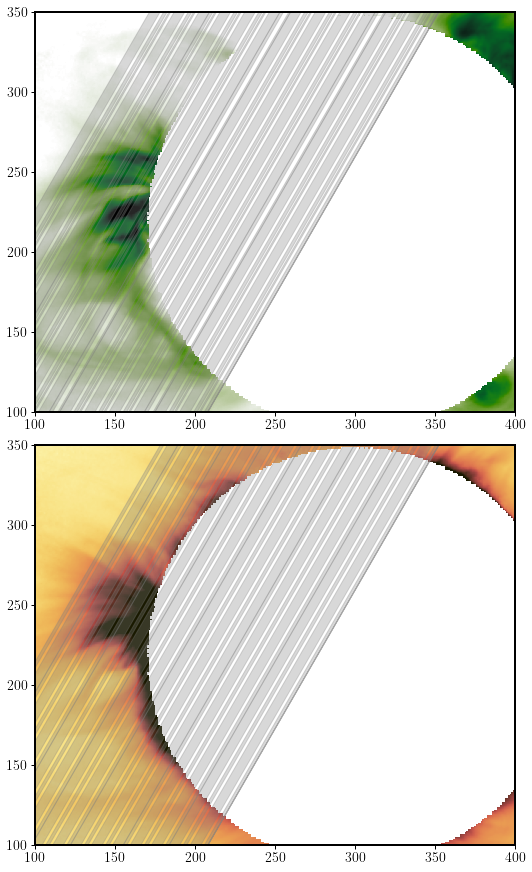

In [184]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,12),constrained_layout=True)

ax1.imshow(FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,cmap=cmr.jungle_r,origin="lower")
ax2.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla,origin="lower")

ax1_xlim = ax1.get_xlim()
ax1_ylim = ax1.get_ylim()
ax2_xlim = ax2.get_xlim()
ax2_ylim = ax2.get_ylim()


for ii, green_row_ in totality_green_df_cut.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    starttime = datetime(2017,8,21,17,45,36)
    time_difference = date_obs - datetime(2017,8,21,17,45,36)
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = sun_center_pixel_plot[0] - slit_xshift_start/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = sun_center_pixel_plot[1] + slit_xshift_start/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = sun_center_pixel_plot[0] - slit_xshift_end/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = sun_center_pixel_plot[1] + slit_xshift_end/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(600,3)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax1.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.3,color="grey")
        

for ii, green_row_ in totality_red_df_cut.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    starttime = datetime(2017,8,21,17,45,36)
    time_difference = date_obs - datetime(2017,8,21,17,45,36)
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = sun_center_pixel_plot[0] - slit_xshift_start/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = sun_center_pixel_plot[1] + slit_xshift_start/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = sun_center_pixel_plot[0] - slit_xshift_end/pixel_ratio*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = sun_center_pixel_plot[1] + slit_xshift_end/pixel_ratio*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(600,3)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax2.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.3,color="grey")



for ax_ in (ax1,ax2):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

xlim_zoomin = (100,400)
ylim_zoomin = (100,350)
ax1.set_xlim(xlim_zoomin)
ax1.set_ylim(ylim_zoomin)
ax2.set_xlim(xlim_zoomin)
ax2.set_ylim(ylim_zoomin)

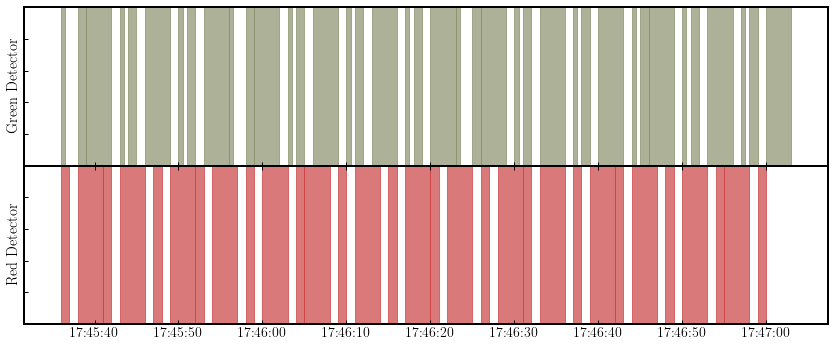

In [217]:
fig = plt.figure(figsize=(12,5),constrained_layout=False)

gs_plot = fig.add_gridspec(nrows=2,ncols=1,hspace=0.,left=0.05,right=0.98,bottom=0.1,top=0.98)
ax1 = fig.add_subplot(gs_plot[0])
ax2 = fig.add_subplot(gs_plot[1])

ax2.get_shared_x_axes().join(ax1,ax2)
ax1.set_ylabel("Green Detector",fontsize=15)
ax2.set_ylabel("Red Detector",fontsize=15)

for ii, green_row_ in totality_green_df_cut.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    obs_end = date_obs + timedelta(seconds=exptime)
    ax1.axvspan(date_obs, obs_end,color="#89916B",alpha=0.7)

for ii, green_row_ in totality_red_df_cut.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    obs_end = date_obs + timedelta(seconds=exptime)
    ax2.axvspan(date_obs, obs_end,color="#CB4042",alpha=0.7)



ax1.tick_params(labelbottom=False,direction="in",labelleft=False)
ax2.tick_params(top=True,direction="in",labelleft=False,labelsize=14)

plt.savefig(fname="../../figs/timeline.png",format="png",dpi=144)



In [212]:
totality_green_df_cut[["date-obs","exptime"]]

date-obs  exptime
0  2017-08-21 17:45:38      1.0
1  2017-08-21 17:45:39      3.0
2  2017-08-21 17:45:36      0.5
3  2017-08-21 17:45:44      1.0
4  2017-08-21 17:45:46      3.0
5  2017-08-21 17:45:43      0.5
6  2017-08-21 17:45:51      1.0
7  2017-08-21 17:45:53      3.0
8  2017-08-21 17:45:50      0.5
9  2017-08-21 17:45:58      1.0
10 2017-08-21 17:45:59      3.0
11 2017-08-21 17:45:56      0.5
12 2017-08-21 17:46:04      1.0
13 2017-08-21 17:46:06      3.0
14 2017-08-21 17:46:03      0.5
15 2017-08-21 17:46:11      1.0
16 2017-08-21 17:46:13      3.0
17 2017-08-21 17:46:10      0.5
18 2017-08-21 17:46:18      1.0
19 2017-08-21 17:46:20      3.0
20 2017-08-21 17:46:17      0.5
21 2017-08-21 17:46:25      1.0
22 2017-08-21 17:46:26      3.0
23 2017-08-21 17:46:23      0.5
24 2017-08-21 17:46:31      1.0
25 2017-08-21 17:46:33      3.0
26 2017-08-21 17:46:30      0.5
27 2017-08-21 17:46:38      1.0
28 2017-08-21 17:46:40      3.0
29 2017-08-21 17:46:37      0.5
30 2017-08-21 17:46:45      1.0
31 2017-08-21 17:46:46      3.0
32 2017-08-21 17:46:44      0.5
33 2017-08-21 17:46:51      1.0
34 2017-08-21 17:46:53      3.0
35 2017-08-21 17:46:50      0.5
36 2017-08-21 17:46:58      1.0
37 2017-08-21 17:47:00      3.0
38 2017-08-21 17:46:57      0.5